In [0]:
# cd '/content/drive/My Drive/Colab Notebooks/Amazon/Data'

In [1]:
!curl -L https://www.dropbox.com/s/qsdq7sx946t39pa/amazon.tar?dl=1 -o amazon.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  637M  100  637M    0     0  41.2M      0  0:00:15  0:00:15 --:--:-- 43.9M


In [2]:
!tar xvf amazon.tar

Streaming output truncated to the last 5000 lines.
amazon/train-jpg/train_19718.jpg
amazon/train-jpg/train_38480.jpg
amazon/train-jpg/train_16787.jpg
amazon/train-jpg/train_621.jpg
amazon/train-jpg/train_28212.jpg
amazon/train-jpg/train_29928.jpg
amazon/train-jpg/train_30979.jpg
amazon/train-jpg/train_12790.jpg
amazon/train-jpg/train_37996.jpg
amazon/train-jpg/train_4564.jpg
amazon/train-jpg/train_423.jpg
amazon/train-jpg/train_15263.jpg
amazon/train-jpg/train_28557.jpg
amazon/train-jpg/train_17206.jpg
amazon/train-jpg/train_28792.jpg
amazon/train-jpg/train_12157.jpg
amazon/train-jpg/train_3899.jpg
amazon/train-jpg/train_34358.jpg
amazon/train-jpg/train_9458.jpg
amazon/train-jpg/train_15756.jpg
amazon/train-jpg/train_6353.jpg
amazon/train-jpg/train_2794.jpg
amazon/train-jpg/train_34451.jpg
amazon/train-jpg/train_11776.jpg
amazon/train-jpg/train_26449.jpg
amazon/train-jpg/train_15881.jpg
amazon/train-jpg/train_21669.jpg
amazon/train-jpg/train_31322.jpg
amazon/train-jpg/train_3449.jpg
am

In [0]:
import pandas as pd
import numpy as np
np.random.seed(0)

import cv2

from tqdm.notebook import tqdm
import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.applications import ResNet50, VGG16

from sklearn.metrics import fbeta_score
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

import gc

In [4]:
import tensorflow.keras.applications
dir(tensorflow.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [0]:
base_models = ['DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception']

In [0]:
for model in base_models:
  exec('from tensorflow.keras.applications import {}'.format(model))

In [7]:
ls

amazon/  amazon.tar  sample_data/


In [8]:
df_train = pd.read_csv('amazon/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
def read_data(df_train, labels, resize=(32, 32)):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in tqdm(df_train.values, miniters=1000):
        if False == os.path.exists('amazon/train-jpg/{}.jpg'.format(f)): continue

        img = cv2.imread('amazon/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(len(label_map))
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.
    
    split = 35000
    
    # X_train, X_test, y_train, y_test
    return X_train[:split], X_train[split:], y_train[:split], y_train[split:]

def score_model(model):
  y_pred = model.predict(X_test, batch_size=128)
  score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

  print("Test score (f1): ", score)
  print("Error: %.2f%%" % (100-score*100))


In [10]:
all_labels = df_train['tags'].map(lambda x: x.split(' ')).values
labels = list(set([y for x in all_labels for y in x]))

print( len(labels), labels )

17 ['water', 'habitation', 'blow_down', 'haze', 'slash_burn', 'clear', 'artisinal_mine', 'conventional_mine', 'blooming', 'selective_logging', 'cultivation', 'agriculture', 'cloudy', 'partly_cloudy', 'primary', 'road', 'bare_ground']


In [11]:
X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(64, 64))

In [12]:
X_train.shape

(35000, 64, 64, 3)

In [13]:
model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(), 

        Dense(256, activation='relu'),
        Dense(17, activation='sigmoid') 
        ])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       7

In [14]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

print()
score_model(model)

Epoch 1/5
274/274 [==============================] - 13s 48ms/step - loss: 0.2462 - accuracy: 0.0085 - val_loss: 0.2257 - val_accuracy: 0.0000e+00
Epoch 2/5
274/274 [==============================] - 12s 44ms/step - loss: 0.2014 - accuracy: 0.0260 - val_loss: 0.1784 - val_accuracy: 0.0613
Epoch 3/5
274/274 [==============================] - 12s 45ms/step - loss: 0.1705 - accuracy: 0.0639 - val_loss: 0.1691 - val_accuracy: 0.0663
Epoch 4/5
274/274 [==============================] - 12s 44ms/step - loss: 0.1503 - accuracy: 0.1353 - val_loss: 0.1436 - val_accuracy: 0.2254
Epoch 5/5
274/274 [==============================] - 12s 45ms/step - loss: 0.1425 - accuracy: 0.1493 - val_loss: 0.1400 - val_accuracy: 0.0663

Test score (f1):  0.868976091906352
Error: 13.10%


##Transfer layrning

In [27]:
del X_train, X_test, y_train, y_test
gc.collect()

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(48, 48))

[2, 3]
[1, 2]


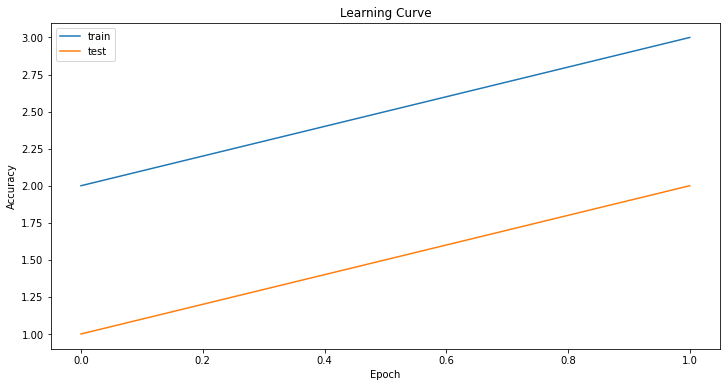

In [51]:
draw_learning_curve([[2,3],[1,2]])

In [17]:
type(history)

tensorflow.python.keras.callbacks.History

In [0]:
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
  plt.figure(figsize=(12,6))

  if type(history) == tensorflow.python.keras.callbacks.History:
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
  else:
    history = list(history)
    train_hiostory = history[0]
    test_hiostory = history[1]

    print(train_hiostory)
    print(test_hiostory)

    plt.plot(train_hiostory)
    plt.plot(test_hiostory)

  plt.title('Learning Curve')
  plt.ylabel(key.title())
  plt.xlabel('Epoch')
  # plt.ylim(ylim)
  plt.legend(['train', 'test'], loc='best')
  plt.show()

In [0]:
train_history = []
test_history = []


def test_base_model(base_model):
  global train_history
  global test_history
  train_history = []
  test_history = []

  model = add_mlp_to_base_model(base_model)

  metrics = ['accuracy']
  optimizer = Adam(0.003, decay=0.0005)
  training_cycle(model, optimizer, metrics, 50)

  draw_learning_curve([train_history, test_history], metrics[0])

def training_cycle(model, optimizer, metrics, epochs):
  global train_history
  global test_history

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
  history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
  
  train_history += history.history[metrics[0]]
  test_history += history.history['val_' + metrics[0]]

def add_mlp_to_base_model(base_model):
  for layer in base_model.layers:
    layer.trainable = False
    
  model = Sequential([
      base_model,
      
      Flatten(), 
          
      Dense(128, activation='relu'),
      Dropout(0.2),
      Dense(17, activation='sigmoid')
      
  ])

  return model

Epoch 1/50
274/274 [==============================] - 11s 41ms/step - loss: 0.1959 - accuracy: 0.0319 - val_loss: 0.1590 - val_accuracy: 0.0411
Epoch 2/50
274/274 [==============================] - 11s 41ms/step - loss: 0.1593 - accuracy: 0.0491 - val_loss: 0.1503 - val_accuracy: 0.0469
Epoch 3/50
274/274 [==============================] - 11s 42ms/step - loss: 0.1522 - accuracy: 0.0549 - val_loss: 0.1466 - val_accuracy: 0.0518
Epoch 4/50
274/274 [==============================] - 12s 42ms/step - loss: 0.1484 - accuracy: 0.0571 - val_loss: 0.1435 - val_accuracy: 0.0542
Epoch 5/50
274/274 [==============================] - 12s 42ms/step - loss: 0.1457 - accuracy: 0.0605 - val_loss: 0.1421 - val_accuracy: 0.0456
Epoch 6/50
274/274 [==============================] - 12s 42ms/step - loss: 0.1440 - accuracy: 0.0592 - val_loss: 0.1409 - val_accuracy: 0.0544
Epoch 7/50
274/274 [==============================] - 11s 42ms/step - loss: 0.1425 - accuracy: 0.0642 - val_loss: 0.1393 - val_accuracy:

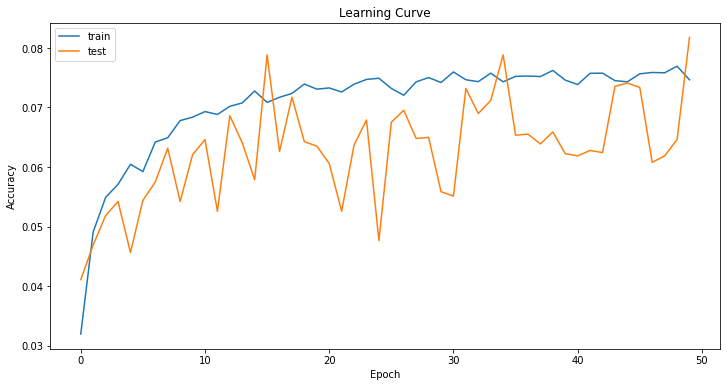

In [54]:
test_base_model(VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))

##VGG16

In [0]:
def add_mlp_to_base_model(base_model):
  for layer in base_model.layers:
    layer.trainable = False
    
  model = Sequential([
      base_model,
      
      Flatten(), 
          
      Dense(128, activation='relu'),
      Dropout(0.2),
      Dense(17, activation='sigmoid')
      
  ])

  return model

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
model = add_mlp_to_base_model(base_model)

optimizer = Adam(0.003, decay=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 17)                2193      
Total params: 14,782,545
Trainable params: 67,857
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/5
274/274 [==============================] - 22s 82ms/step - loss: 0.2008 - accuracy: 0.0510 - val_loss: 0.1611 - val_accuracy: 0.0531
Epoch 2/5
274/274 [==============================] - 22s 81ms/step - loss: 0.1617 - accuracy: 0.0548 - val_loss: 0.1516 - val_accuracy: 0.0396
Epoch 3/5
274/274 [==============================] - 22s 82ms/step - loss: 0.1538 - accuracy: 0.0617 - val_loss: 0.1480 - val_accuracy: 0.0498
Epoch 4/5
274/274 [==============================] - 22s 82ms/step - loss: 0.1499 - accuracy: 0.0689 - val_loss: 0.1439 - val_accuracy: 0.0558
Epoch 5/5
274/274 [==============================] - 22s 80ms/step - loss: 0.1468 - accuracy: 0.0735 - val_loss: 0.1425 - val_accuracy: 0.0540


In [0]:
for layer in model.layers[0].layers[:-5]:
  layer.trainable = True

optimizer = Adam(0.0003, decay=0.000005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

print()
score_model(model)

Epoch 1/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1820 - accuracy: 0.1191 - val_loss: 0.1506 - val_accuracy: 0.3546
Epoch 2/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1353 - accuracy: 0.2053 - val_loss: 0.1273 - val_accuracy: 0.2771
Epoch 3/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1270 - accuracy: 0.2133 - val_loss: 0.1170 - val_accuracy: 0.1057
Epoch 4/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1194 - accuracy: 0.2367 - val_loss: 0.1109 - val_accuracy: 0.3052
Epoch 5/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1132 - accuracy: 0.2362 - val_loss: 0.1078 - val_accuracy: 0.1091
Epoch 6/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1105 - accuracy: 0.2030 - val_loss: 0.1087 - val_accuracy: 0.1040
Epoch 7/10
274/274 [==============================] - 55s 201ms/step - loss: 0.1066 - accuracy: 0.1887 - val_loss: 0.1067 - val_ac

In [0]:
base_models

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception']